In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

%matplotlib inline

import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Gaukhar-ai/for_my_Thinkful_work/master/capstone/Stock%20Market_1B_predictions/stock_market_data.csv')
df.head()

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,...,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
0,ZYME,8269000.0,3.091,9007000.0,636578000.0,-3.765,-37487000.0,48686718.0,0.170,-35880000.0,...,-162932000.0,-2.154,3.091,-0.358217,-4.339097835,-0.823549,0.181661,-16.467038,6.807722,0.014149
1,ZYME,1877000.0,7.288,6881000.0,368205000.0,-38.489,-36354000.0,43658717.0,0.043,-73752000.0,...,-145437000.0,-2.319,7.288,-0.409374,-39.29248801,-0.922987,0.047655,-19.603277,3.647265,0.018688
2,ZYME,7860000.0,3.146,6755000.0,400037000.0,-3.877,-10880000.0,43445379.0,0.181,-33564000.0,...,-63920000.0,0.004,3.146,-0.197080,-4.270229008,-0.277127,0.200204,6200.000000,6.678431,0.016886
3,ZYME,7882000.0,2.112,7829000.0,414547000.0,-3.689,-13317000.0,32837975.0,0.240,-29432000.0,...,-52196000.0,0.028,2.112,-0.191239,-3.734077645,-0.415356,0.245839,785.714286,8.874183,0.018886
4,ZYME,11925000.0,3.048,8065000.0,238279000.0,-1.144,-21302000.0,32020437.0,0.372,-14553000.0,...,-28993000.0,0.616,3.048,-0.130571,-1.220377358,-0.665162,0.372362,26.266234,6.440652,0.033847


In [3]:
df_copy = df.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40277 entries, 0 to 40276
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ticker                   40277 non-null  object 
 1   revenue                  39949 non-null  float64
 2   pb                       38433 non-null  float64
 3   debt                     39416 non-null  float64
 4   assets                   39416 non-null  float64
 5   netmargin                38980 non-null  float64
 6   ncfo                     39683 non-null  float64
 7   shareswa                 40072 non-null  float64
 8   sps                      39800 non-null  float64
 9   opinc                    39949 non-null  float64
 10  assetsc                  30302 non-null  float64
 11  liabilitiesc             30265 non-null  float64
 12  price                    38513 non-null  float64
 13  calendardate             40277 non-null  object 
 14  datekey               

In [5]:
df['datekey'].nunique()

584

In [6]:
(df['datekey'] == df['calendardate']).mean() # 83% they match. 


0.8301015467884897

In [7]:
df['calendardate'].unique() #'12/31/2019', '9/30/2019' pick this quarter, merge by Ticker
#add next quarters price. compute the return 

array(['3/31/2020', '12/31/2019', '9/30/2019', '6/30/2019', '3/31/2019',
       '12/31/2018', '9/30/2018', '6/30/2018', '3/31/2018', '12/31/2017',
       '9/30/2017', '6/30/2017', '3/31/2017', '12/31/2016', '12/31/2015',
       '9/30/2016', '6/30/2016', '3/31/2016', '9/30/2015', '6/30/2015',
       '3/31/2015', '6/30/2020'], dtype=object)

In [8]:
df['datekey']

0         3/31/2020
1        12/31/2019
2         9/30/2019
3         6/30/2019
4         3/31/2019
            ...    
40272     4/30/2016
40273     1/31/2016
40274    10/31/2015
40275     7/31/2015
40276     4/30/2015
Name: datekey, Length: 40277, dtype: object

In [15]:
df_date = df[df['calendardate'] == '12/31/2019' - '9/30/2019']

TypeError: unsupported operand type(s) for -: 'str' and 'str'

df['calendardate'] = pd.to_datetime(df['calendardate'])
df['year'] = df['calendardate'].dt.year
df['month'] = df['calendardate'].dt.month
df['day'] = df['calendardate'].dt.day

In [10]:
drop_cols = ['datekey', 'calendardate', ]
df.drop(columns = drop_cols, inplace=True)

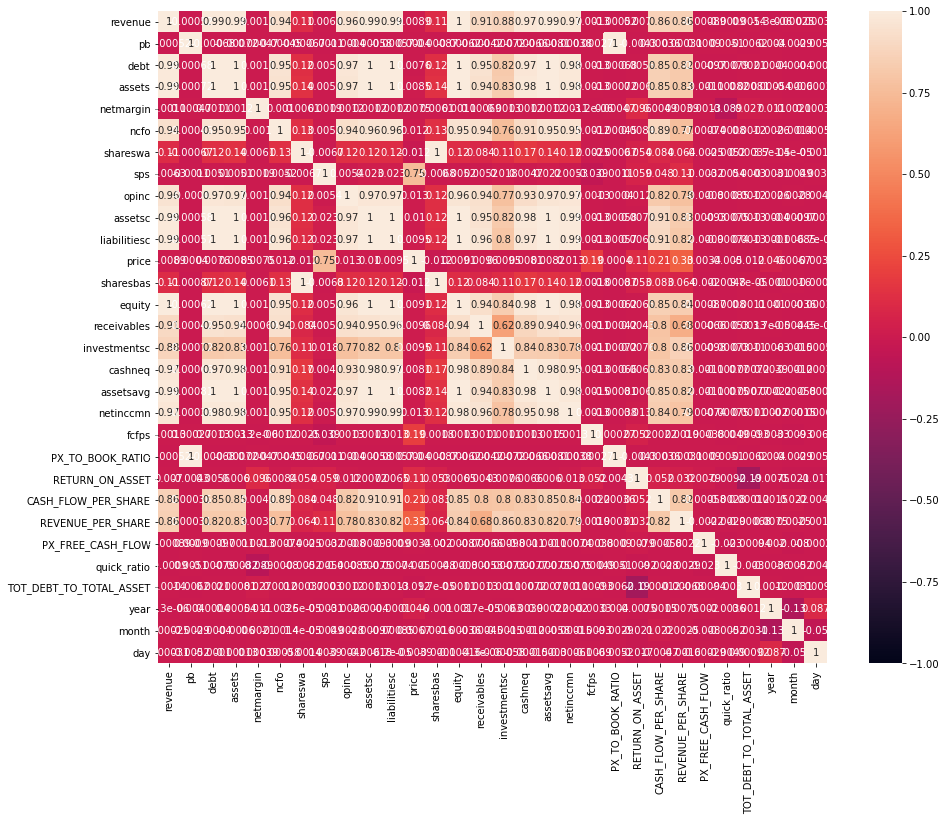

In [11]:
plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [ ]:
#standardscale

In [ ]:
#look at sigma and check, whaterver has the highest = keep it. std()
#sector to keep. binary doesnt need corr. 

how to convert tickers to numbers?

# Standarizing the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [12]:
#scaled_df = scale(df)

In [ ]:
#take one quarter of the data = 2000 samples, ticker can drop when doing cluster, 
clean, no corr
standard scaler
cluster

In [ ]:
Oper_MARGIN check is it has nAS, upper case cols
work with row numbers, drop the upper case. 


In [ ]:
#try 100 samples first then all

scaler = StandardScaler()
df = scaler.fit_transform(all_data)